# Lab 9

We would like to use different optimization methods for linear regression

In [36]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_theme(rc={'figure.figsize' : (20,8)})

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Regressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# Metrics
from sklearn.metrics import mean_squared_error

# set display options
pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.max_columns', 100)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Prep
We load the nifty index data from Kannan's github

In [37]:
# load nifty index data
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv',
index_col=0,
dayfirst=True)

We get a quick summary of the basic statistics of this model

In [38]:
df.describe()

,Open,High,Low,Close,Volume
count,"2,719.0000","2,719.0000","2,719.0000","2,719.0000","2,719.0000"
mean,"10,124.8980","10,175.2921","10,057.4698","10,117.5710","289,222,065.6433"
std,"3,709.6071","3,725.5270","3,685.3052","3,706.9455","195,276,778.8519"
min,"4,640.2000","4,645.9500","4,588.0500","4,636.7500","2,826,000.0000"
25%,"7,637.0000","7,681.0000","7,581.6500","7,623.8000","159,178,008.0000"
50%,"9,376.9500","9,431.9000","9,301.3500","9,351.8500","219,496,064.0000"
75%,"11,700.8500","11,755.1250","11,631.3250","11,684.0000","340,908,832.0000"
max,"18,871.9500","18,887.6000","18,778.2000","18,812.5000","1,810,971,008.0000"


Conveniently, the data is cleaned, as we see below

In [39]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### Feature Engineering

Here, a feature is the independent variables used to determine the value of the target variable. We create some typical features for finance data.

In [40]:
def create_features(frame):
    df = frame.copy()
    multiplier = 2

    # define features
    
    df['OC'] = df['Close'] / df['Open'] - 1 # Open/Close relative difference
    df['HC'] = df['High'] / df['Low'] - 1 # High/Low relative difference
    df['GAP'] = df['Open'] / df['Close'].shift(1) - 1 # Gap between consecutive opens & closes
    df['RET'] = np.log(df['Close'] / df['Close'].shift(1)) # log returns

    # Similar values, but for rolling windows of 1w, 2w, 3w
    for i in [7, 14, 28]:
        df['PCHG' + str(i)] = df['Close'].pct_change(i)
        df['VCHG' + str(i)] = df['Volume'].pct_change(i)
        df['RET' + str(i)] = df['RET'].rolling(i).sum()
        df['MA' + str(i)] = df['Close'] / df['Close'].rolling(i).mean()
        df['VMA' + str(i)] = df['Volume'] / df['Volume'].rolling(i).mean()
        df['OC'+ str(i)] = df['OC'].rolling(i).mean()
        df['HC'+ str(i)] = df['HC'].rolling(i).mean()
        df['GAP'+ str(i)] = df['GAP'].rolling(i).mean()
        df['STD'+ str(i)] = df['RET'].rolling(i).std()
        df['UB'+str(i)] = df['Close'].rolling(i).mean() + df['Close'].rolling(i).std() * multiplier
        df['LB'+str(i)] = df['Close'].rolling(i).mean() - df['Close'].rolling(i).std() * multiplier

    # drop NaN values
    df['Label'] = df['Close'].shift(-1)
    df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

### Feature Specification

In [41]:
# features
df1 = create_features(df)
display(df1.shape)
# verify the output
df1.head(2)

(2690, 38)

,OC,HC,GAP,RET,PCHG7,VCHG7,RET7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,LB7,PCHG14,VCHG14,RET14,MA14,VMA14,OC14,HC14,GAP14,STD14,UB14,LB14,PCHG28,VCHG28,RET28,MA28,VMA28,OC28,HC28,GAP28,STD28,UB28,LB28,Label
10/02/2012,-0.0034,0.0162,-0.0023,-0.0057,0.0279,-0.0406,0.0275,1.0058,0.9455,0.0008,0.0145,0.0032,0.0065,"5,442.1990","5,259.1296",0.0660,0.0195,0.0639,1.0249,1.0192,0.0020,0.0142,0.0026,0.0107,"5,486.1450","5,015.7836",0.1606,1.0777,0.1490,1.0646,1.0967,0.0029,0.0138,0.0024,0.0104,"5,509.5275","4,600.9761","5,390.2000"
13/02/2012,0.0015,0.0130,0.0001,0.0016,0.0228,-0.4628,0.0226,1.0042,0.8406,0.0011,0.0146,0.0022,0.0064,"5,428.6264","5,307.0736",0.0682,0.1478,0.0659,1.0217,0.8150,0.0018,0.0146,0.0030,0.0106,"5,489.4954","5,061.5689",0.1311,0.2383,0.1232,1.0616,0.8783,0.0023,0.0135,0.0022,0.0094,"5,534.1504","4,620.9889","5,416.0500"


### Target/Label Definition
The target or lable is the dependent variable. Here, we define the target variable to be the closing price of the index the next trading day.

In [42]:
# label
y = np.array(df1['Label'])
y

array([ 5390.2 ,  5416.05,  5531.95, ..., 18122.5 , 18191.  , 18105.3 ])

### Feature Selection

We need to trim the input variables to the ones we expect to be useful to the model. We use correlation measures, one of the filter methods to address multicollinearity among features.

Text(0.5, 1.0, 'Features Set Correlations')

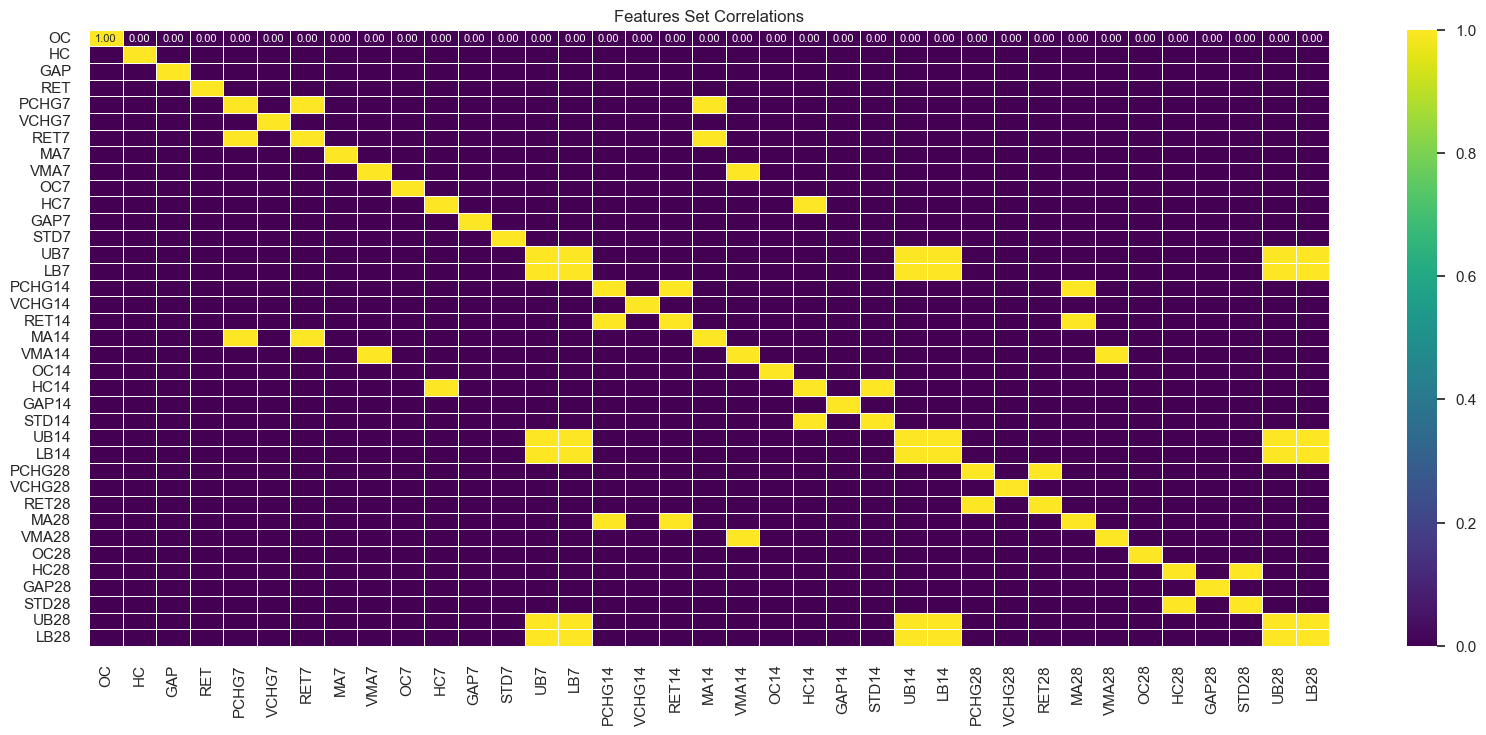

In [43]:
# drop label from dataframe
df1.drop('Label', axis=1, inplace=True)

# Detect and remove features that are highly correlated
sns.heatmap(df1.corr() > 0.9,
            annot=True,
            annot_kws={'size' : 8},
            fmt='.2f',
            linewidths=0.5,
            cmap='viridis',
            cbar=True)

plt.title('Features Set Correlations')

In [44]:
# Remove heavily correlated features
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = df1.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [45]:
# total correlated features
drop_correlated_features = correlated_features(df1)
# drop the highly correlated features
X = df1.drop(drop_correlated_features, axis=1)
# record feature names
feature_names = X.columns

In [46]:
# display the new features set
X

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
10/02/2012,-0.0034,0.0162,-0.0023,-0.0057,0.0279,-0.0406,1.0058,0.9455,0.0008,0.0145,0.0032,0.0065,"5,442.1990",0.0660,0.0195,0.0020,0.0026,0.1606,1.0777,0.0029,0.0138,0.0024
13/02/2012,0.0015,0.0130,0.0001,0.0016,0.0228,-0.4628,1.0042,0.8406,0.0011,0.0146,0.0022,0.0064,"5,428.6264",0.0682,0.1478,0.0018,0.0030,0.1311,0.2383,0.0023,0.0135,0.0022
14/02/2012,0.0066,0.0093,-0.0017,0.0048,0.0169,-0.0734,1.0066,0.9424,0.0006,0.0138,0.0018,0.0057,"5,438.1094",0.0563,-0.0030,0.0014,0.0026,0.1403,0.2138,0.0027,0.0134,0.0020
15/02/2012,0.0131,0.0149,0.0082,0.0212,0.0318,0.4616,1.0235,1.3794,0.0030,0.0143,0.0015,0.0091,"5,529.6862",0.0724,0.4343,0.0022,0.0028,0.1646,0.7675,0.0032,0.0136,0.0023
16/02/2012,0.0015,0.0087,-0.0033,-0.0018,0.0350,0.4904,1.0166,1.1224,0.0053,0.0131,-0.0003,0.0086,"5,566.1259",0.0610,0.2507,0.0025,0.0018,0.1615,0.5339,0.0030,0.0131,0.0024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,-0.0095,0.0152,-0.0083,-0.0178,-0.0457,0.0645,0.9767,1.1157,-0.0050,0.0132,-0.0017,0.0085,"18,669.0039",-0.0478,-0.2321,-0.0025,-0.0010,-0.0324,-0.1175,-0.0009,0.0090,-0.0003
26/12/2022,0.0103,0.0174,0.0013,0.0116,-0.0217,-0.0354,0.9912,0.8942,-0.0020,0.0136,-0.0011,0.0103,"18,604.7406",-0.0337,-0.1888,-0.0019,-0.0005,-0.0215,-0.1944,-0.0005,0.0094,-0.0002
27/12/2022,0.0023,0.0101,0.0042,0.0065,-0.0075,-0.2283,0.9987,1.1366,-0.0013,0.0136,0.0002,0.0106,"18,577.5673",-0.0231,0.0686,-0.0014,-0.0002,-0.0115,0.0685,-0.0004,0.0096,0.0000
28/12/2022,0.0021,0.0058,-0.0026,-0.0005,-0.0162,0.2520,1.0005,0.9989,-0.0020,0.0129,-0.0003,0.0098,"18,464.3870",-0.0262,-0.0441,-0.0014,-0.0004,-0.0101,-0.0248,-0.0002,0.0094,-0.0001


### Exploratory Data Analysis of remaining features
We will use this data to determine what scaling techniques we must use

In [47]:
# decide which scaling to use
X.describe()

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
count,"2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000"
mean,-0.0007,0.0119,0.0012,0.0005,0.0036,0.1016,1.0014,1.0024,-0.0007,0.0119,0.0012,0.0090,"10,363.3054",0.0074,0.1658,-0.0007,0.0012,0.0153,0.1229,-0.0007,0.0119,0.0012
std,0.0089,0.0082,0.0063,0.0108,0.0283,1.9471,0.0147,0.2179,0.0030,0.0061,0.0026,0.0058,"3,755.5770",0.0405,4.8659,0.0021,0.0020,0.0566,2.2287,0.0015,0.0050,0.0014
min,-0.0682,0.0025,-0.0914,-0.1390,-0.2294,-0.9925,0.8703,0.0094,-0.0159,0.0050,-0.0287,0.0014,"4,937.6487",-0.3164,-0.9904,-0.0108,-0.0205,-0.3675,-0.9919,-0.0072,0.0059,-0.0100
25%,-0.0051,0.0073,-0.0010,-0.0046,-0.0119,-0.1811,0.9930,0.8633,-0.0025,0.0087,0.0002,0.0058,"7,849.8332",-0.0138,-0.1996,-0.0018,0.0004,-0.0164,-0.2094,-0.0015,0.0091,0.0005
50%,-0.0005,0.0100,0.0015,0.0007,0.0053,0.0021,1.0029,0.9701,-0.0006,0.0107,0.0013,0.0080,"9,681.1755",0.0092,-0.0056,-0.0006,0.0013,0.0187,-0.0117,-0.0006,0.0110,0.0013
75%,0.0039,0.0139,0.0039,0.0062,0.0198,0.2130,1.0103,1.1034,0.0012,0.0136,0.0024,0.0106,"11,955.6179",0.0312,0.2298,0.0006,0.0022,0.0513,0.2552,0.0003,0.0134,0.0020
max,0.0931,0.1875,0.0448,0.0840,0.1463,98.2647,1.0654,2.4288,0.0140,0.0904,0.0156,0.0735,"18,937.7871",0.1879,251.1766,0.0061,0.0131,0.2088,112.8719,0.0035,0.0536,0.0074


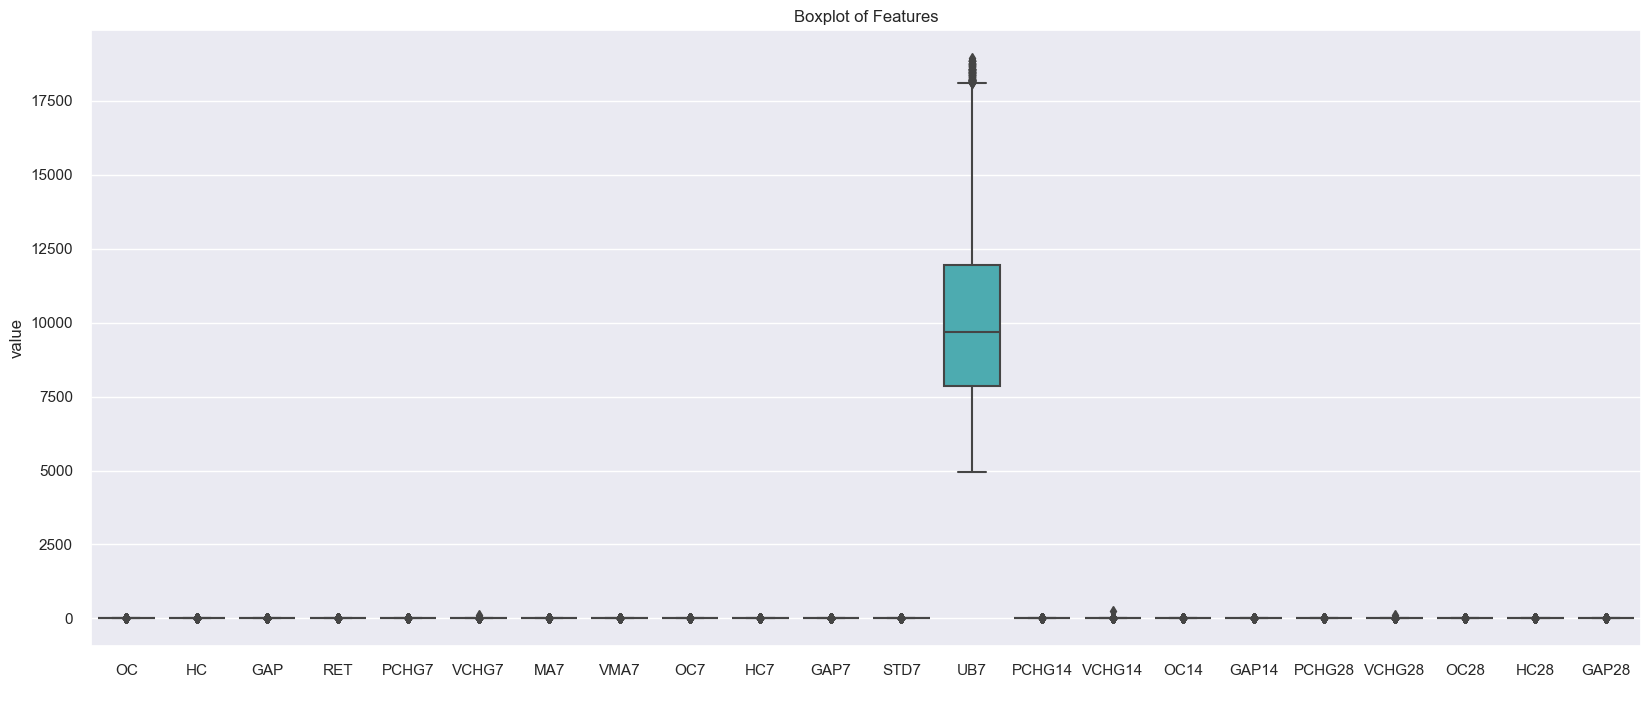

In [48]:
# study the distribution
# fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x='variable', y='value', data=pd.melt(X))
plt.xlabel(' ')
plt.title('Boxplot of Features');

### Regression class

Time to make the class!

In [51]:
class Regression:
    def __init__(self, X, y, testsize=0.2) -> None:
        self.X = X
        self.y = y
        self.testsize = testsize

        # split training and testing dataset
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,
                                                                                self.y,
                                                                                test_size=testsize,
                                                                                random_state=0,
                                                                                shuffle=False)
        

    def fit_predict(self, estimator, transformer, alpha=None, l1_ratio=None):
        """
        Fit and predict
        """
        try:
            # subsume estimators and transformer into a pipeline
            model = Pipeline([('scaler', transformer),
                              ('regressor', estimator)])
            
            # fit/train model
            model.fit(self.X_train, self.y_train)

            # predict labels
            y_pred = model.predict(self.X_test)
        
        except Exception as e:
            print(str(e))

        return model, model['regressor'].intercept_, model['regressor'].coef_, y_pred
    
    
    def eval_metrics(self, model, y_pred):
        """
        Evaluate received metrics
        """
        
        mse = mean_squared_error(self.y_test, y_pred, squared=True)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2train = model.score(self.X_train, self.y_train)
        r2test = model.score(self.X_test, self.y_test)

        return mse, rmse, r2train, r2test
    
    def plot_coeff(self, modelname):
        """
        Plot coefficients as a function of lambda
        """

        coef = []
        model = Regression(self.X, self.y, 0.2)
        alpha_range = np.logspace(2, -2, 200)

        if modelname == 'Lasso':
            for i in alpha_range:
                coef.append(model.fit_predict(Lasso(alpha=i, random_state=0), MinMaxScaler())[2])

        elif modelname == 'Ridge':
            alpha_range = np.logspace(6, -2, 200)
            for i in alpha_range:
                coef.append(model.fit_predict(Ridge(alpha=i, random_state=0), MinMaxScaler())[2])

        elif modelname == 'ElasticNet':
            for i in alpha_range:
                coef.append(model.fit_predict(ElasticNet(alpha=i, random_state=0), MinMaxScaler())[2])

        # Plot Coefficients
        fig = plt.figure(figsize=(20,8))
        ax = plt.axes()
        ax.plot(alpha_range, coef)
        ax.set_xscale('log')
        ax.legend(feature_names, loc=0)
        # ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
        ax.set_title(f'{modelname} coefficients as a function of the regularization')
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('$\mathbf{w}$')
        return plt.show()

### Linear regression
Here, the model coefficients are selected by minimizing a loss function. We must first instantiate the class object, then pass the estimator and transformer to fit and predict the model.

In [53]:
# Instantiate
lr = Regression(X, y)

# Fit Linear Regression
lr_model , lr_intercept, lr_coef, lr_y_pred = lr.fit_predict(LinearRegression(), 
                                                             MinMaxScaler())
print(f"\n Model: {lr_model} \n Intercept: {lr_intercept} \n Coefficients: \n{lr_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', LinearRegression())]) 
 Intercept: 2908.506115524673 
 Coefficients: 
[-15152.54289514     59.84289711 -12842.72788099  21034.50509902
 -19638.64573201   -142.85365193   1597.25036071    -52.90704977
  10784.88855444   -962.93763779  16332.59580405   -805.73544021
   7407.17868876   3038.94103025     35.51362605  -1389.86239819
  -2663.16545765   3632.37495083    -59.69122303  -1932.98166345
    271.73920383  -3142.66928796]


### Regularized Regression
If the coefficients are too large in linear regression, there may be overfitting. We use regularization to penalize these large coefficients. We use Lasso (L1) and Ridge (L2) regression to prevent over-fitting.

#### LASSO
It is known as Least Absolute Shrinkage and Selection Operator, which works on the L1 norm of the weights, penalizing the MSE. It is controlled by a regularization penalty constant, $\lambda > 0$.

In [54]:
# instantiate
lasso = Regression(X,y)

# fit Lasso
lasso_model , lasso_intercept, lasso_coef, lasso_y_pred = lasso.fit_predict(Lasso(alpha=0.3, random_state=0), MinMaxScaler())
print(f"\n Model: {lasso_model} \n Intercept: {lasso_intercept} \n Coefficients:\n {lasso_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Lasso(alpha=0.3, random_state=0))]) 
 Intercept: 3732.9973444928537 
 Coefficients:
 [ 0.00000000e+00 -2.55913938e+02  0.00000000e+00  1.10784982e+00
 -0.00000000e+00 -0.00000000e+00  1.60540227e+03 -3.28647147e+01
 -7.18927619e+01 -7.52779897e+02  2.95170917e+02 -4.53689390e+02
  7.39904013e+03  0.00000000e+00 -0.00000000e+00  2.97289445e+01
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  5.91509957e+01 -0.00000000e+00]


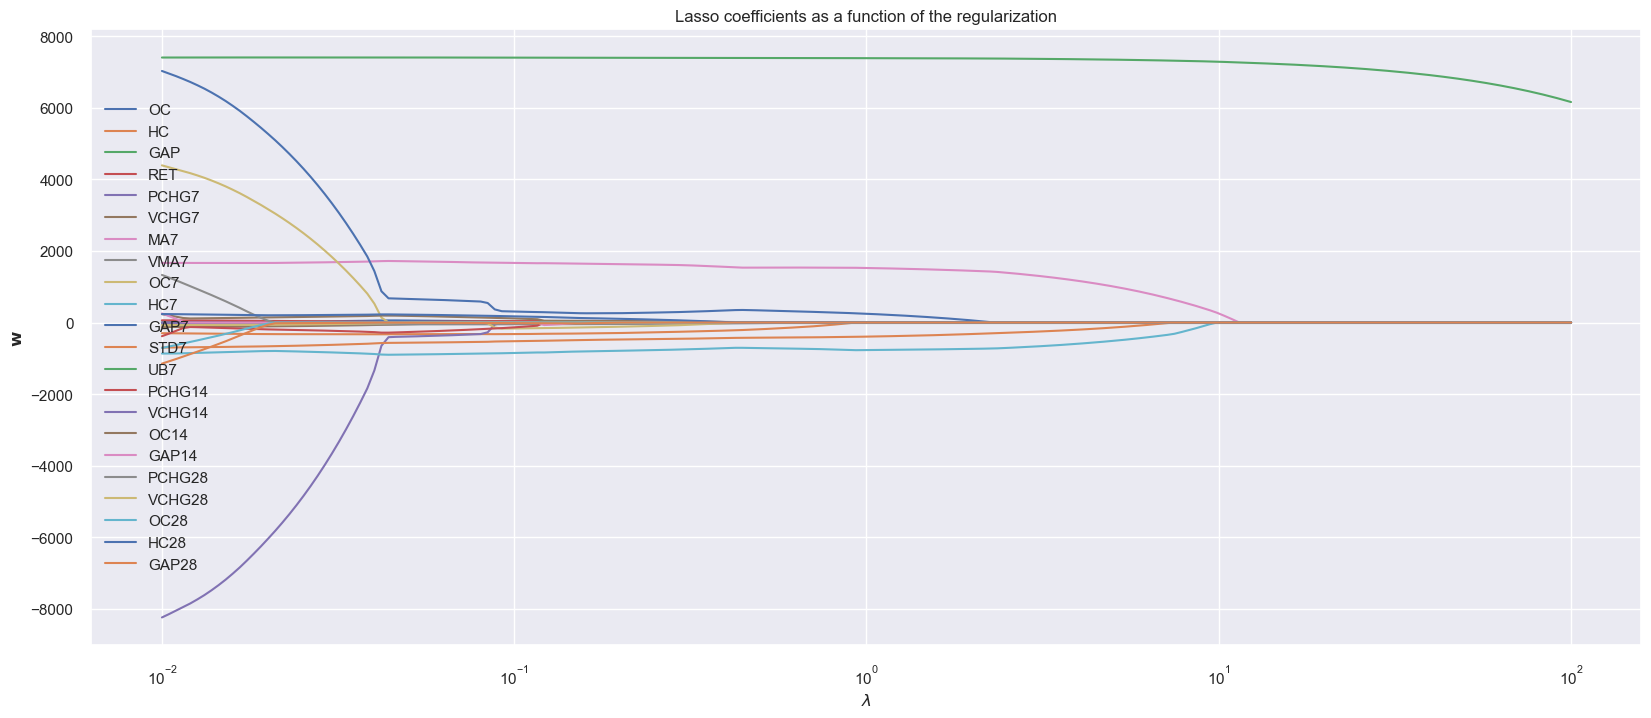

In [55]:
# plot coefficients
lasso.plot_coeff('Lasso')

#### Ridge
Here, we use the L2 norm of the weights, penalizing the MSE. It is controlled by a regularization penalty constant, $\lambda > 0$.

In [56]:
# instantiate
ridge = Regression(X,y)

# fit Ridge
ridge_model , ridge_intercept, ridge_coef, ridge_y_pred = ridge.fit_predict(Ridge(alpha=1, random_state=0), MinMaxScaler())
print(f"\n Model: {ridge_model} \n Intercept: {ridge_intercept} \n Coefficients:\n {ridge_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Ridge(alpha=1, random_state=0))]) 
 Intercept: 3619.2549859099845 
 Coefficients:
 [ 1.28772303e+02 -4.27306449e+02  7.88508714e+01  1.61908109e+02
  8.38082694e+01 -6.98335661e+01  1.22981148e+03 -4.44082200e+01
 -6.88128333e+01 -6.68893291e+02  4.65282201e+02 -4.90945476e+02
  7.35982645e+03 -8.62009614e+01  1.44824650e+01  1.20876762e+02
  3.02986138e+01  1.89294187e+01 -5.87469715e+01 -1.87182123e+01
  8.31896901e+01 -2.15278456e+00]


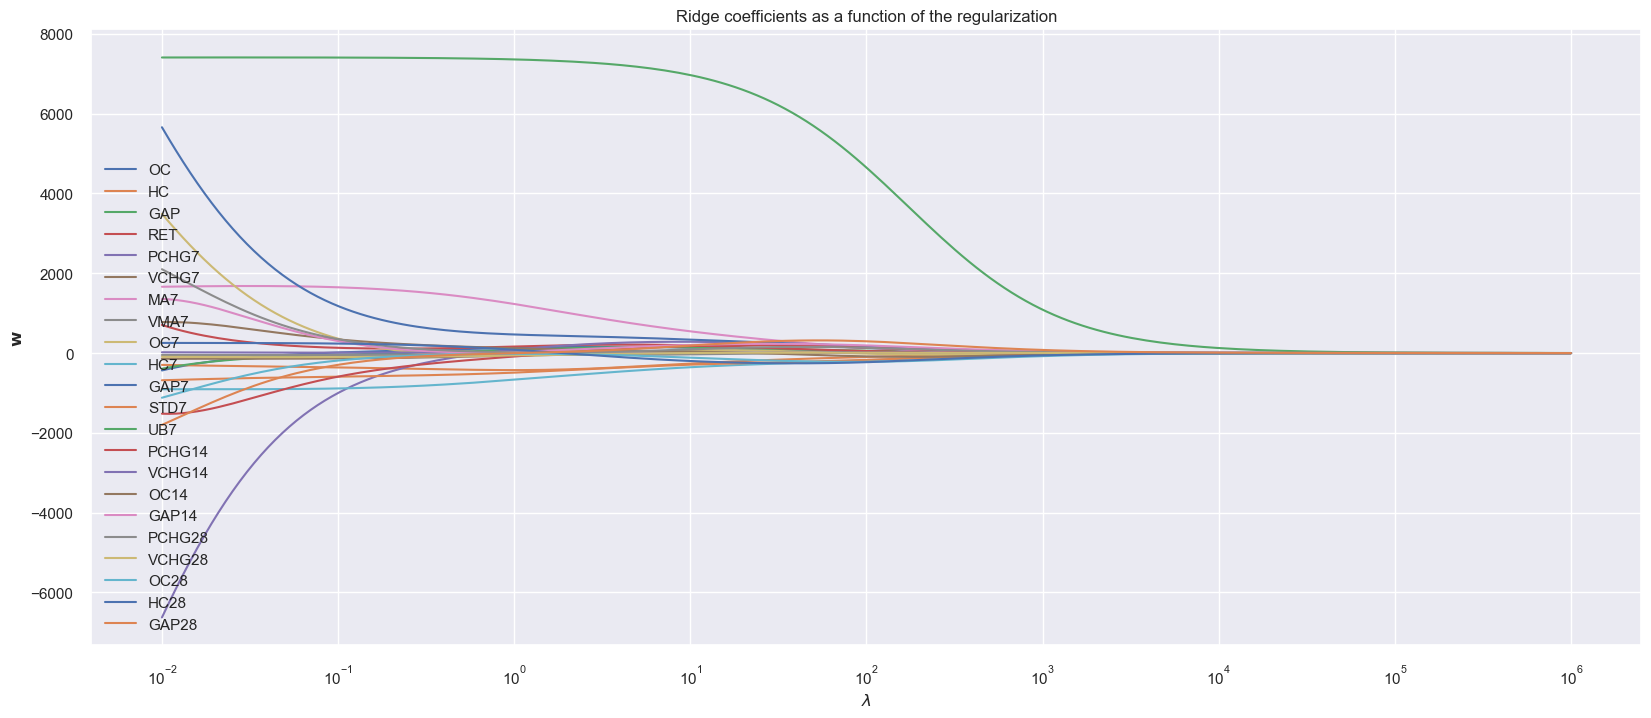

In [57]:
# plot coefficients
ridge.plot_coeff('Ridge')

#### ElasticNet Regression
This uses a weighted sum of the L1 & L2 norm with weight $0 \leq \alpha \leq 1$, where $\alpha \rightarrow 0^+$ results in more weight to L2, whereas $\alpha \rightarrow 1^-$ puts more weight to L1. It is a linear interpolation in particular.

In [58]:
# instantiate
elasticnet = Regression(X,y)

# fit ElasticNet
elasticnet_model , elasticnet_intercept, elasticnet_coef, elasticnet_y_pred = elasticnet.fit_predict(ElasticNet(alpha=0.1, l1_ratio=1e-10, random_state=0), MinMaxScaler())
print(f"\n Model: {elasticnet_model} \n Intercept: {elasticnet_intercept} \n Coefficients: \n {elasticnet_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 ElasticNet(alpha=0.1, l1_ratio=1e-10, random_state=0))]) 
 Intercept: 6645.386223460456 
 Coefficients: 
 [ 1.75682329e+00 -6.13715450e+01  3.65559957e+01  2.40675785e+01
  6.97654783e+01  5.73092061e+00  6.99802581e+01  1.14483995e+01
 -3.99993493e+01 -1.24120026e+02  1.12501660e+02 -1.19079553e+02
  3.27144632e+03  8.20142148e+01  6.28152417e+00 -9.37415200e+01
  1.37059662e+02  8.83471228e+01  6.83709138e+00 -1.88942989e+02
 -1.70520833e+02  2.23373717e+02]


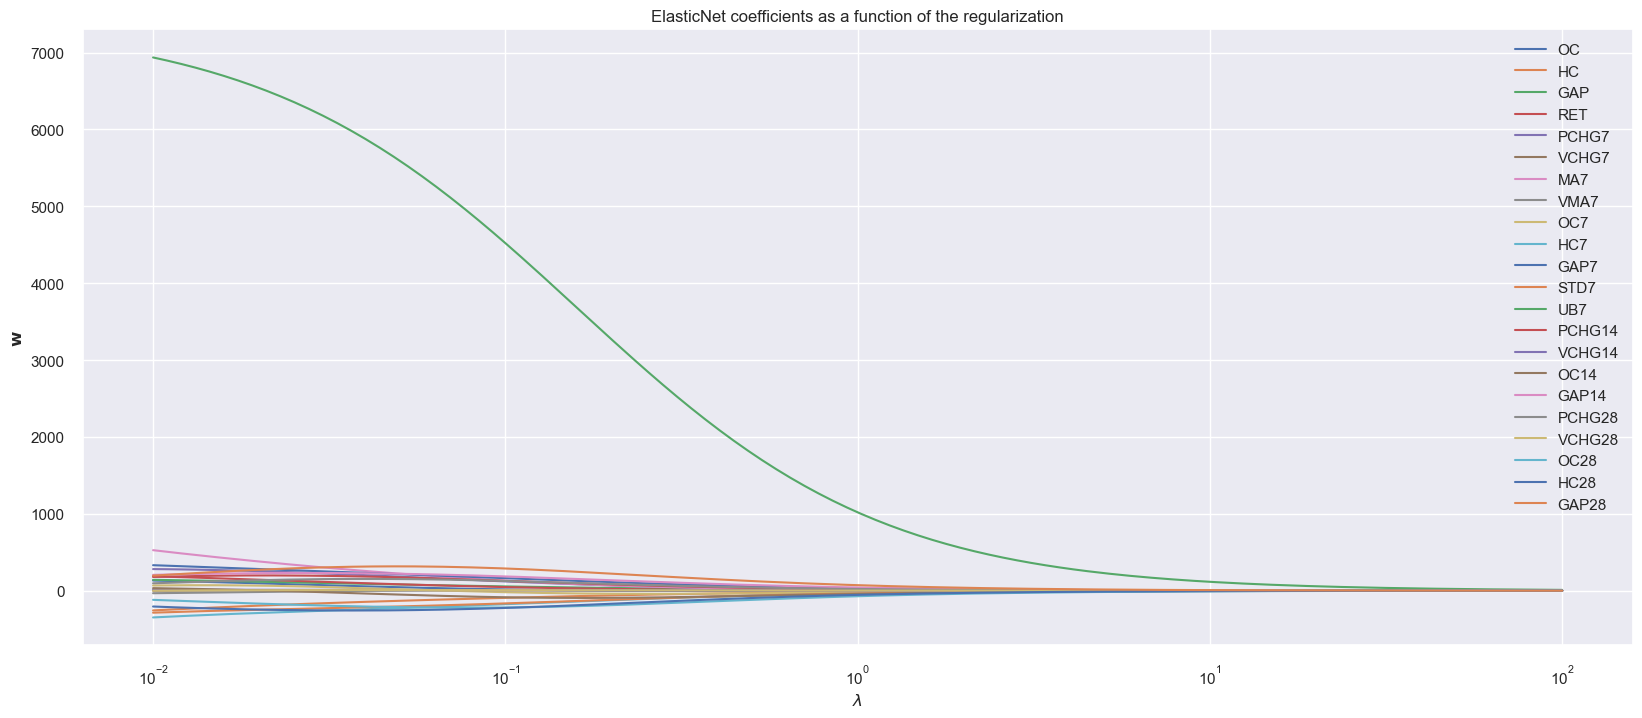

In [59]:
# plot coefficients
elasticnet.plot_coeff('ElasticNet')

### Model Comparison

In [60]:
# compare model coefficients
coef_df = pd.DataFrame({
    'LR': lr_coef,
    'Lasso': lasso_coef,
    'Ridge': ridge_coef,
    'ElasticNet': elasticnet_coef
}, index = feature_names)

coef_df

,LR,Lasso,Ridge,ElasticNet
OC,"-15,152.5429",0.0000,128.7723,1.7568
HC,59.8429,-255.9139,-427.3064,-61.3715
GAP,"-12,842.7279",0.0000,78.8509,36.5560
RET,"21,034.5051",1.1078,161.9081,24.0676
PCHG7,"-19,638.6457",-0.0000,83.8083,69.7655
VCHG7,-142.8537,-0.0000,-69.8336,5.7309
MA7,"1,597.2504","1,605.4023","1,229.8115",69.9803
VMA7,-52.9070,-32.8647,-44.4082,11.4484
OC7,"10,784.8886",-71.8928,-68.8128,-39.9993
HC7,-962.9376,-752.7799,-668.8933,-124.1200


In [61]:
# compare evaluation metrics
eval_df = pd.DataFrame({
    'LR': lr.eval_metrics(lr_model, lr_y_pred),
    'Lasso': lasso.eval_metrics(lasso_model, lasso_y_pred),
    'Ridge': ridge.eval_metrics(ridge_model, ridge_y_pred),
    'ElasticNet': elasticnet.eval_metrics(elasticnet_model, elasticnet_y_pred)
}, index = ['MSE', 'RMSE', 'R2_train', 'R2_test'])

eval_df

,LR,Lasso,Ridge,ElasticNet
MSE,"52,464.1724","55,841.4103","60,390.4692","19,581,731.0662"
RMSE,229.0506,236.3079,245.7447,"4,425.1250"
R2_train,0.9969,0.9964,0.9963,0.6907
R2_test,0.9777,0.9762,0.9743,-7.3406
